In [ ]:
import datetime
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
sns.set_theme(context='talk', style='whitegrid', palette='deep')
plt.rcParams['figure.figsize'] = 10, 7
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['figure.titlesize'] = 32
plt.rcParams['axes.titlesize'] = 32
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['figure.autolayout'] = 'true'
plt.rcParams['figure.frameon'] = 'false'
plt.rcParams['axes.spines.left'] = 'false'
plt.rcParams['axes.spines.right'] = 'false'
plt.rcParams['axes.spines.top'] = 'false'
plt.rcParams['legend.fancybox'] = 'false'
plt.rcParams['axes.spines.bottom'] = 'false'
plt.rcParams['font.size'] = 20
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
# для графиков, где надо много цветов, юзайте воть:
sns.set_palette(sns.color_palette('deep'))
# а по дефолту воть:
# sns.set_palette(sns.color_palette('BuGn_r', n_colors=10)[2::3])
pd.set_option('display.max_columns', 60)

In [ ]:
feeding_details_22 = pd.read_csv('datasets/2022-feeding-tasks-details.csv', on_bad_lines='skip')
feeding_22 = pd.read_csv('datasets/2022-feeding-tasks.csv', on_bad_lines='skip')

feeding_details_23 = pd.read_csv('datasets/2023-feeding-tasks-details.csv', on_bad_lines='skip')
feeding_23 = pd.read_csv('datasets/2023-feeding-tasks.csv', on_bad_lines='skip')

feeding_details_24 = pd.read_csv('datasets/2024-feeding-tasks-details.csv', on_bad_lines='skip')
feeding_24 = pd.read_csv('datasets/2024-feeding-tasks.csv', on_bad_lines='skip')

feeding_details_25 = pd.read_csv('datasets/2025-feeding-tasks-details.csv', on_bad_lines='skip')
feeding_25 = pd.read_csv('datasets/2025-feeding-tasks.csv', on_bad_lines='skip')

monthly_feeding = pd.read_excel('datasets/Ekoniva_dataset.xlsx', sheet_name='Feeding (monthly)', header=1).iloc[1:, :]
herd_metrics = pd.read_excel('datasets/Ekoniva_dataset.xlsx', sheet_name='Herd maintenance', header=1).replace('-', np.nan).iloc[1:, :]
production_indicators = pd.read_excel('datasets/Ekoniva_dataset.xlsx', sheet_name='Dairy indicators', header=1).replace('-', np.nan).iloc[1:, :]

In [3]:
out = pd.read_csv('datasets//out.csv', index_col=0)

In [4]:
df = out.copy()

In [5]:
def func(name):
    if ('D' in name or 'Д' in name) and len(name) <= 5:
        return name.replace('D', 'Д')
    if name == 'С1' or name == 'С2' or name == 'Нетели':
        return name
    return None
group_names = [func(name) for name in out.PhysiologicalGroupName.unique() if func(name)]

In [7]:
union = pd.merge(herd_metrics, production_indicators, on=['date', 'farm_name'], how='left')
union['date'] = pd.to_datetime(union['date'])

In [9]:
df['date'] = pd.to_datetime(df['Date'])
data = pd.merge(df.rename(columns={'FarmName': 'farm_name'}), union, on=['date', 'farm_name'])

### собираем векторы ингредиентов за месяц &rarr; агрегируем вес на корову по месяцу, ферме, группе и типу ингредиента

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

out['Date'] = pd.to_datetime(out['Date'], errors='coerce')
out_filt = out[out['PhysiologicalGroupName'].isin(group_names)].copy()
out_filt['year_month'] = out_filt['Date'].dt.to_period('M').astype(str)

monthly_agg = (
    out_filt
    .groupby(
        ['year_month', 'FarmName', 'PhysiologicalGroupName', 'IngredientType'],
        as_index=False
    )['WeightPerCow']
    .sum()
)

monthly_vectors = monthly_agg.pivot_table(
    index=['year_month', 'FarmName', 'PhysiologicalGroupName'],
    columns='IngredientType',
    values='WeightPerCow',
    aggfunc='sum'
).fillna(0)

monthly_vectors.reset_index(inplace=True)

feature_cols = [c for c in monthly_vectors.columns
                if c not in ['year_month', 'FarmName', 'PhysiologicalGroupName']]

### Матрица признаков (подготовка для РСА)

In [12]:
X = monthly_vectors[feature_cols].astype(float).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(
    X_scaled,
    columns=feature_cols,
    index=monthly_vectors.index
)

### Функция для расчет дистанции

In [14]:
def compute_pairwise_distances_between_farms(monthly_vectors, X_scaled_df, metric='euclidean'):
    '''
    Для каждого (year_month, PhysiologicalGroupName) считаем попарные расстояния
    между фермами по вектору ингредиентов.

    metric: 'euclidean' или 'manhattan'
    '''
    rows = []

    # пробегаем по месяцам и группам
    for (ym, grp), idx in monthly_vectors.groupby(
        ['year_month', 'PhysiologicalGroupName']
    ).groups.items():
        idx = list(idx)
        if len(idx) < 2:
            continue  # нет пары ферм — нечего считать

        # подматрица признаков
        X_sub = X_scaled_df.loc[idx].values
        farms = monthly_vectors.loc[idx, 'FarmName'].tolist()

        # матрица расстояний
        dist_mat = pairwise_distances(X_sub, metric=metric)

        # приводим к 'длинному' формату (верхний треугольник)
        n = len(farms)
        for i in range(n):
            for j in range(i + 1, n):
                rows.append({
                    'year_month': ym,
                    'PhysiologicalGroupName': grp,
                    'Farm1': farms[i],
                    'Farm2': farms[j],
                    'distance': dist_mat[i, j],
                    'metric': metric
                })

    return pd.DataFrame(rows)


dist_farms_euclid = compute_pairwise_distances_between_farms(
    monthly_vectors, X_scaled_df, metric='euclidean'
)

dist_farms_manhattan = compute_pairwise_distances_between_farms(
    monthly_vectors, X_scaled_df, metric='manhattan'
)

### Расстояни по месяцам для одной фермы

In [15]:
def compute_temporal_distances(monthly_vectors, X_scaled_df, metric='euclidean'):
    '''
    Для каждой фермы и группы считает расстояние между
    последовательными месяцами (t -> t+1).
    '''
    rows = []

    # сортируем по времени с помощью периода
    monthly_vectors = monthly_vectors.copy()
    monthly_vectors['ym_period'] = monthly_vectors['year_month'].map(lambda s: pd.Period(s))

    for (farm, grp), df_fg in monthly_vectors.groupby(['FarmName', 'PhysiologicalGroupName']):
        df_fg = df_fg.sort_values('ym_period')
        idx_list = df_fg.index.to_list()

        if len(idx_list) < 2:
            continue

        for i in range(len(idx_list) - 1):
            idx_t = idx_list[i]
            idx_t1 = idx_list[i + 1]

            x_t = X_scaled_df.loc[idx_t].values.reshape(1, -1)
            x_t1 = X_scaled_df.loc[idx_t1].values.reshape(1, -1)

            d = pairwise_distances(x_t, x_t1, metric=metric)[0, 0]

            rows.append({
                'FarmName': farm,
                'PhysiologicalGroupName': grp,
                'year_month_t': monthly_vectors.loc[idx_t, 'year_month'],
                'year_month_t1': monthly_vectors.loc[idx_t1, 'year_month'],
                'distance': d,
                'metric': metric
            })

    return pd.DataFrame(rows)


dist_temporal_euclid = compute_temporal_distances(
    monthly_vectors, X_scaled_df, metric='euclidean'
)

dist_temporal_manhattan = compute_temporal_distances(
    monthly_vectors, X_scaled_df, metric='manhattan'
)

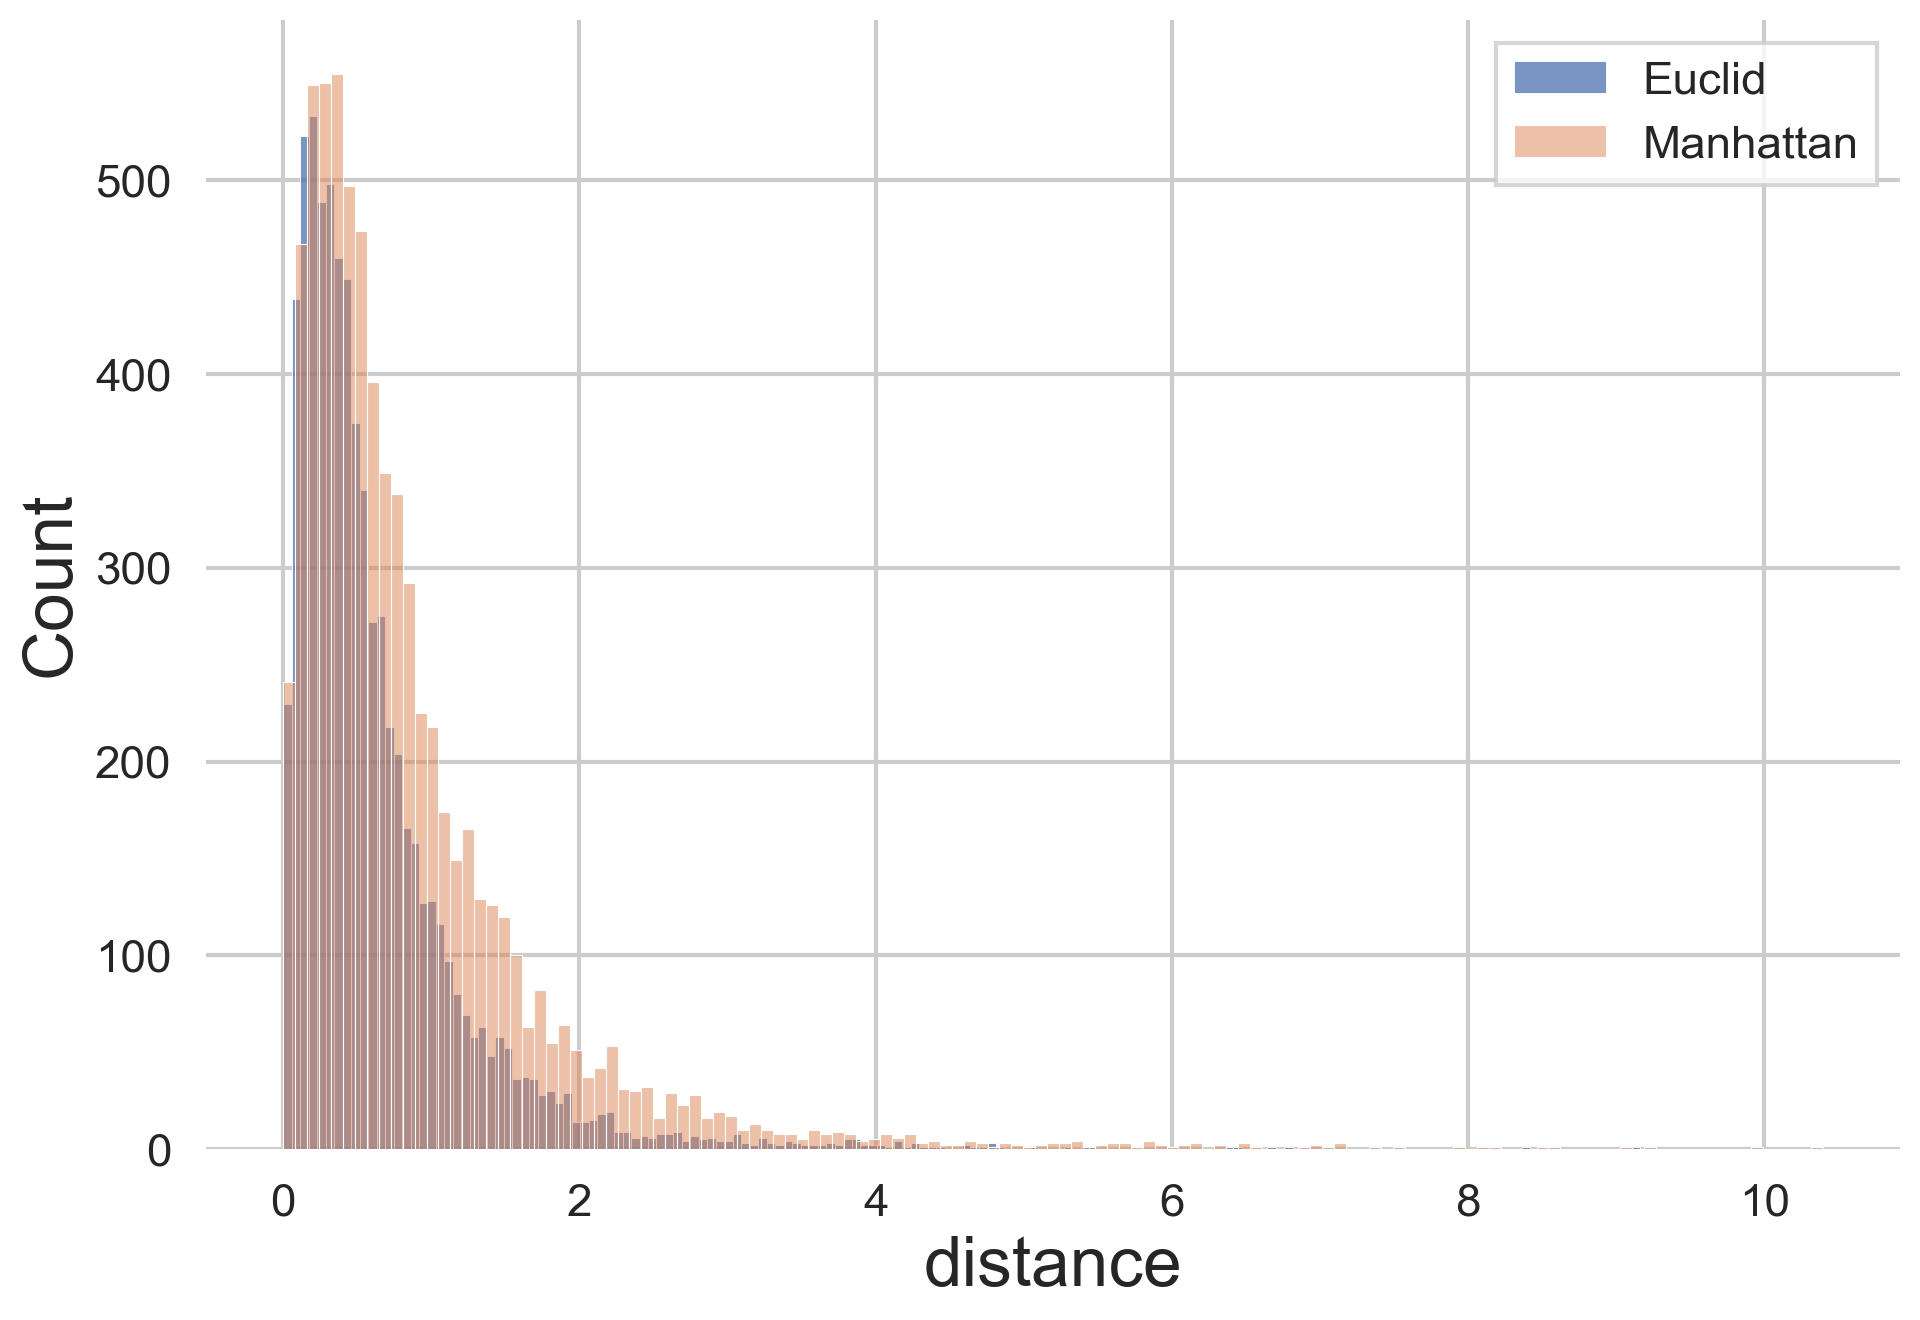

In [17]:
sns.histplot(data=dist_temporal_euclid, x='distance', label='Euclid')
sns.histplot(data=dist_temporal_manhattan, x='distance', alpha=0.5, label='Manhattan')
plt.legend()
plt.show()

### Переходим к PCA

In [18]:
# центр
center = X_scaled_df.mean(axis=0).values.reshape(1, -1)

monthly_vectors["dist_to_center_euclid"] = pairwise_distances(
    X_scaled_df.values, center, metric="euclidean"
)[:, 0]

monthly_vectors["dist_to_center_manhattan"] = pairwise_distances(
    X_scaled_df.values, center, metric="manhattan"
)[:, 0]

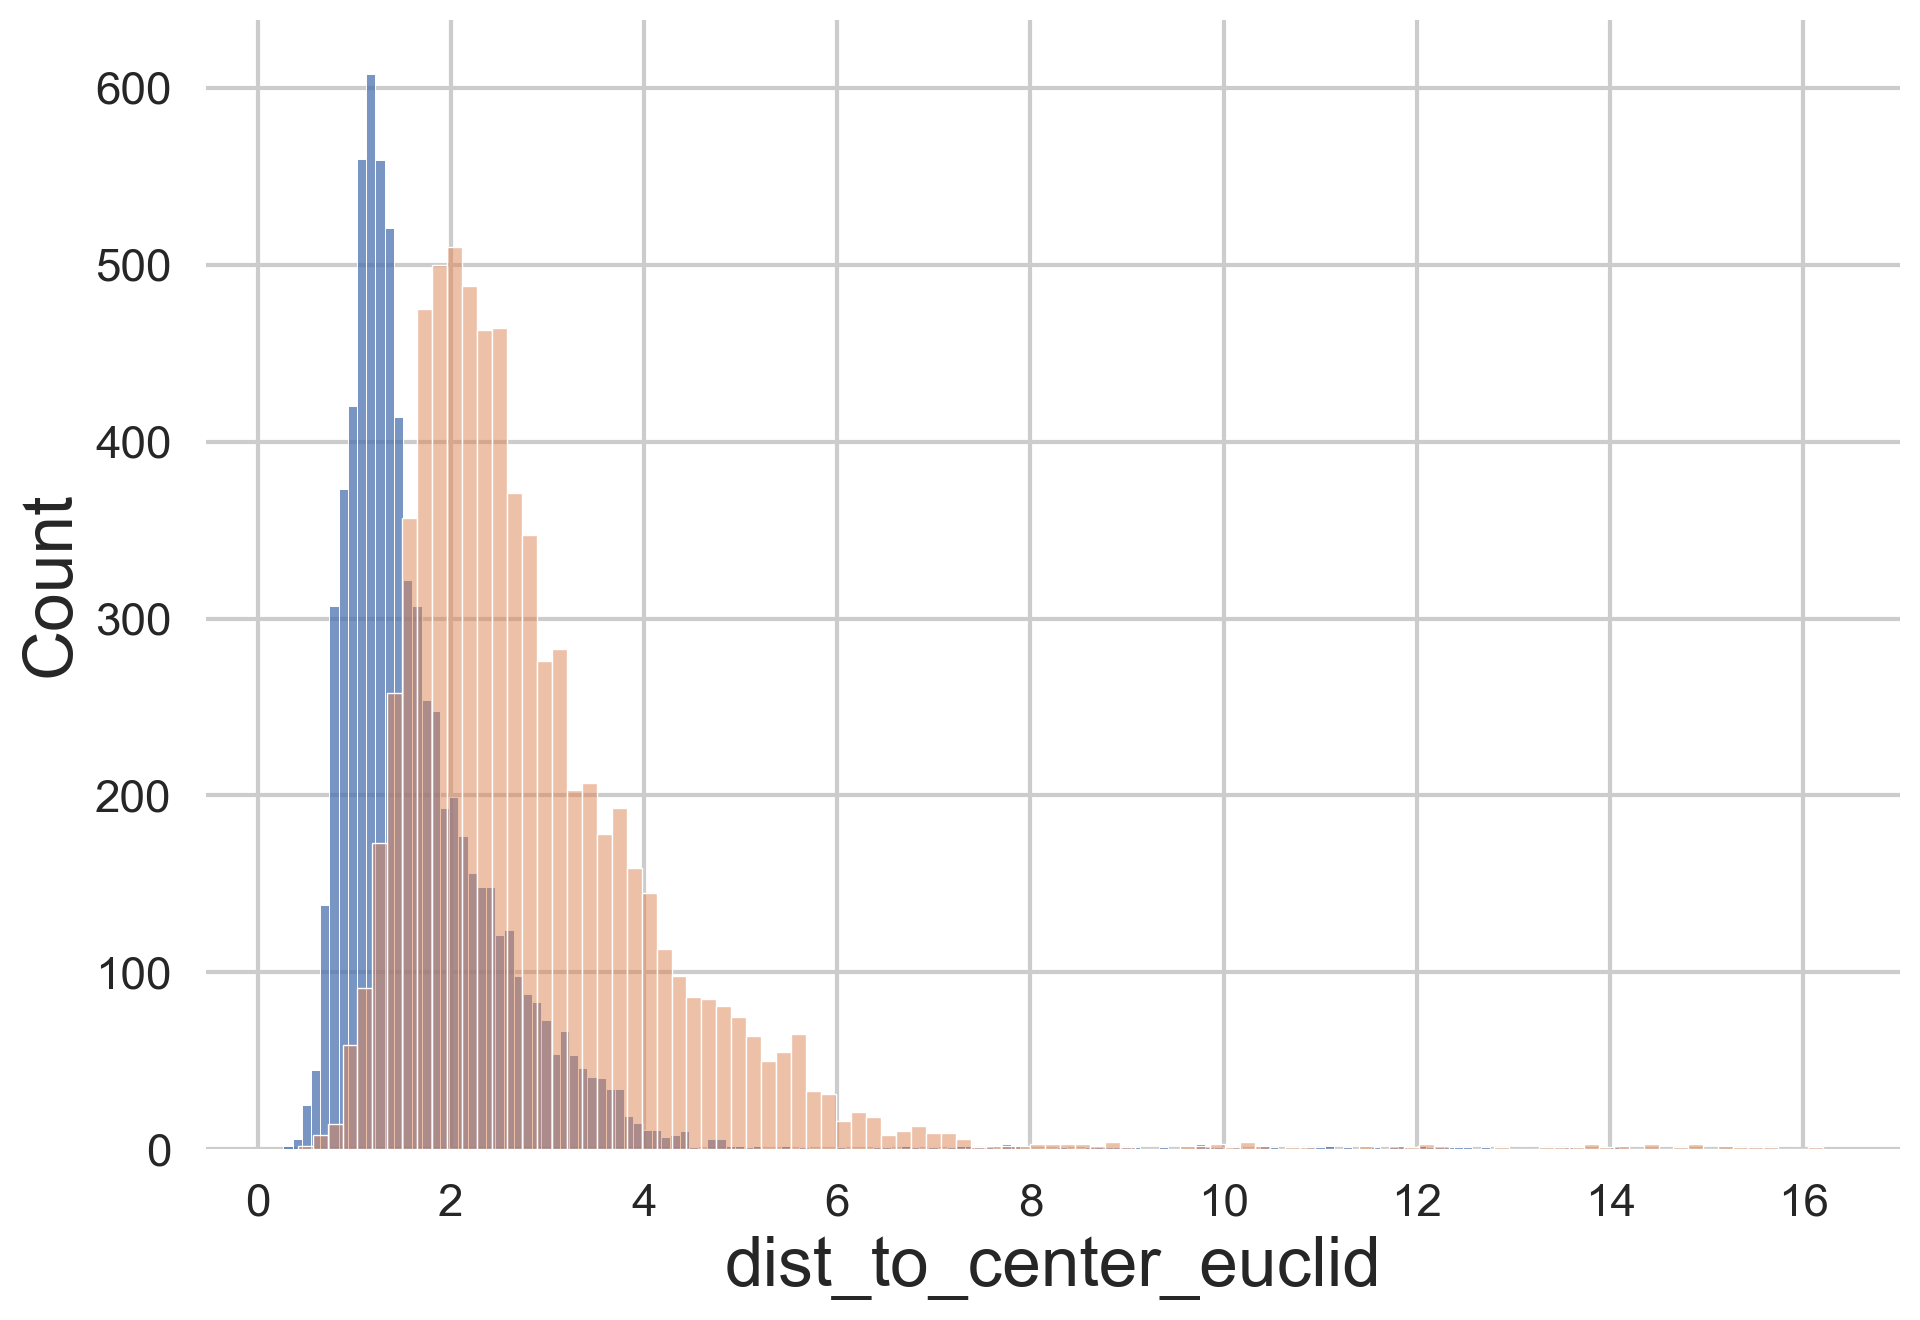

In [19]:
sns.histplot(data=monthly_vectors, x='dist_to_center_euclid', label='Euclid')
sns.histplot(data=monthly_vectors, x='dist_to_center_manhattan', alpha=0.5, label='Manhattan')
plt.show()

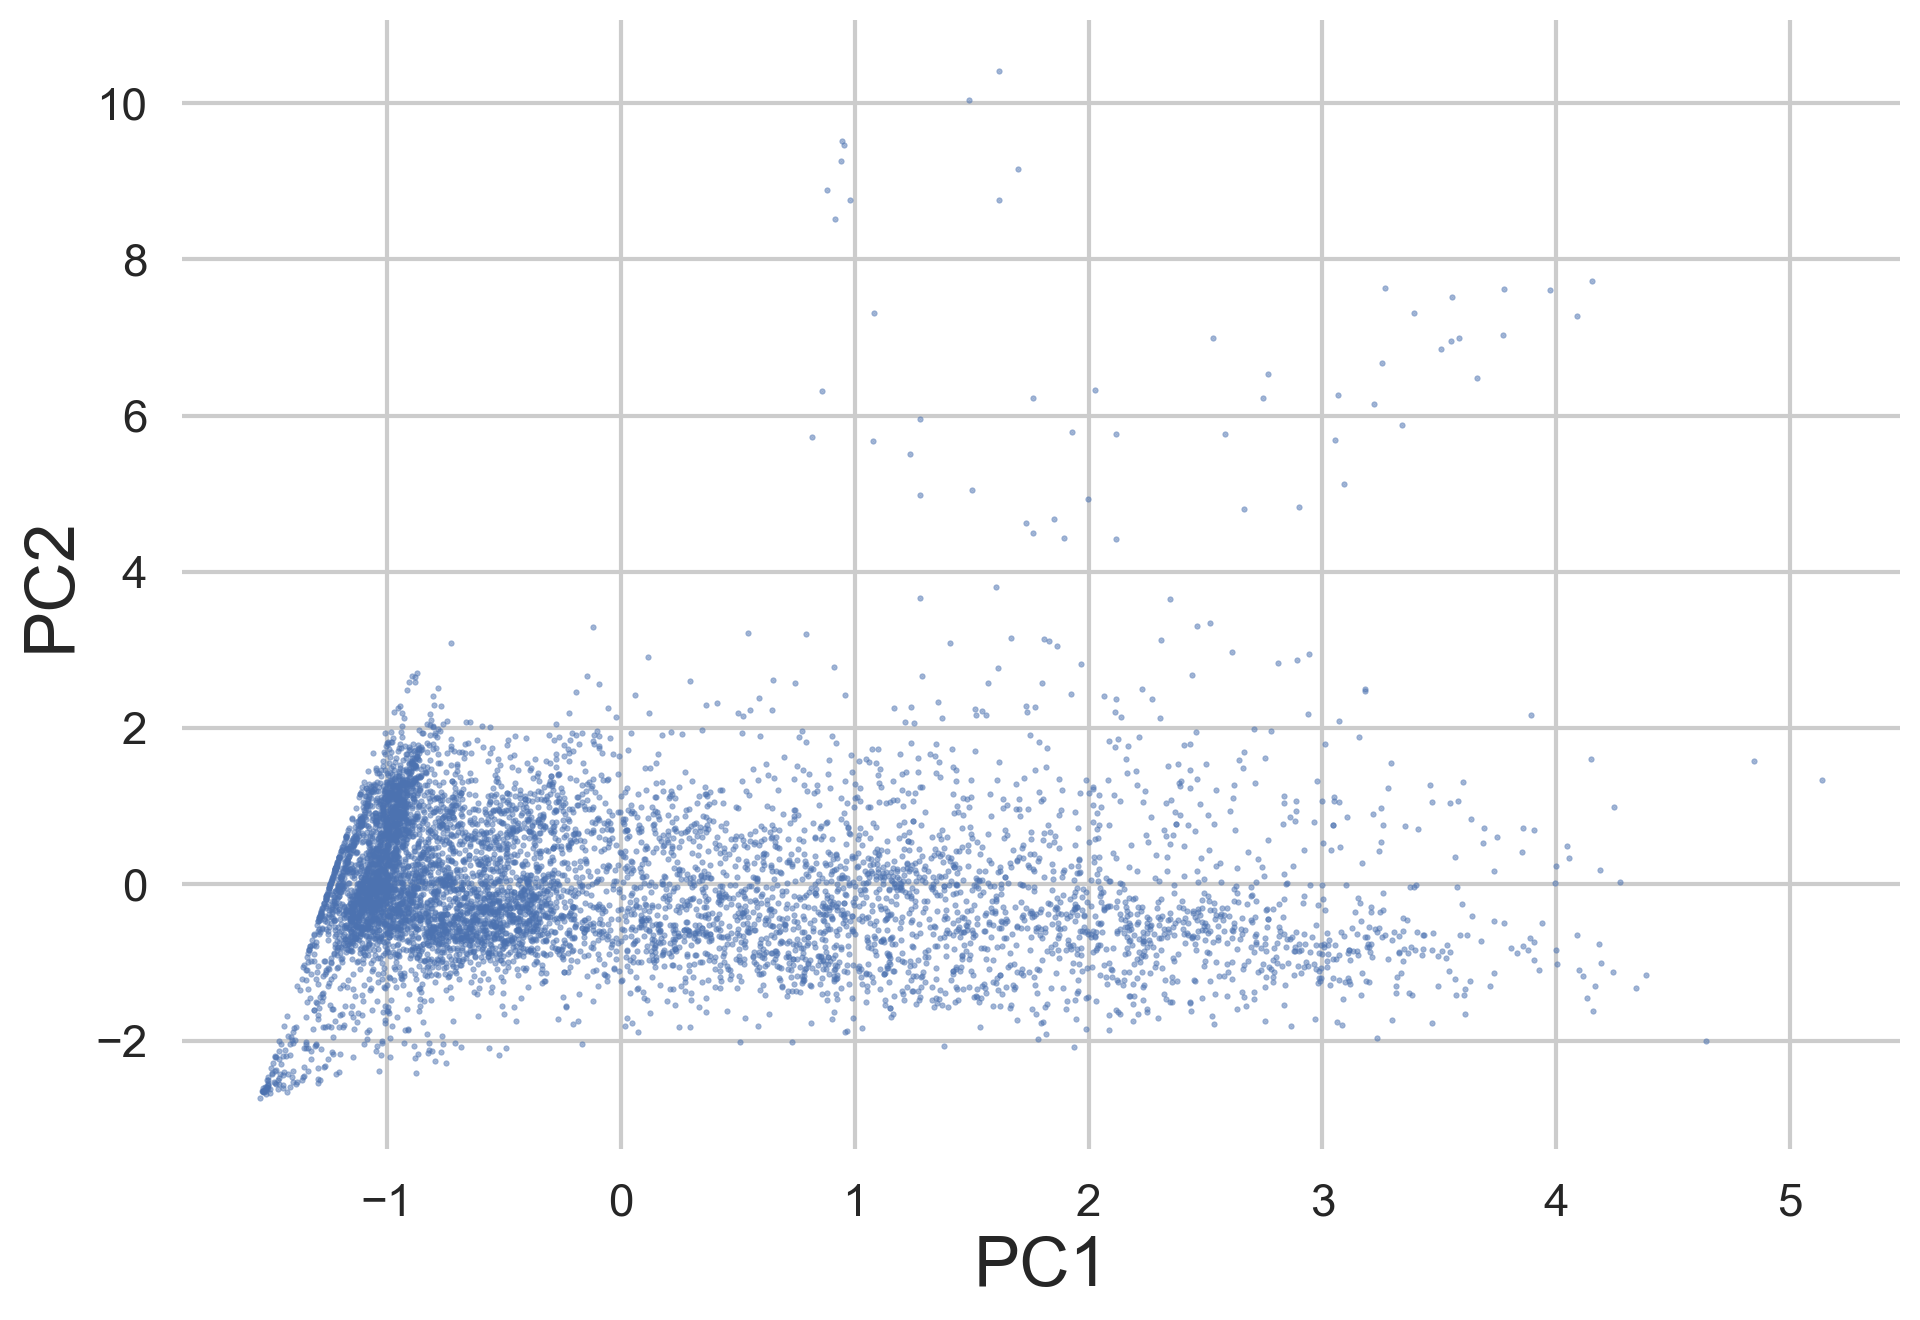

In [22]:
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X_scaled_df.values)

monthly_vectors["pca1"] = pca_coords[:, 0]
monthly_vectors["pca2"] = pca_coords[:, 1]
# простое отображение получившейся плоскости
plt.scatter(monthly_vectors["pca1"], monthly_vectors["pca2"], alpha=0.6, s=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [23]:
monthly_vectors

IngredientType,year_month,FarmName,PhysiologicalGroupName,Concentrate,Forage,VitaminMineral,Water,dist_to_center_euclid,dist_to_center_manhattan,pca1,pca2
0,2022-01,ЖК Добрино,Д1,340.062794,702.705964,2.862242,122.201750,1.393270,2.626717,1.089064,-0.850710
1,2022-01,ЖК Добрино,Д2,324.793632,915.401888,4.452705,137.319180,1.317608,2.210917,1.243220,-0.154619
2,2022-01,ЖК Добрино,Нетели,27.865941,778.464953,5.992175,4.964982,1.130613,1.890230,-1.071388,-0.130798
3,2022-01,ЖК Добрино,С1,0.000000,975.969602,5.962783,0.000000,1.341200,2.272867,-1.157442,0.488731
4,2022-01,ЖК Добрино,С2,155.370434,711.753724,31.426965,113.003896,1.874432,3.145199,0.572646,0.538384
...,...,...,...,...,...,...,...,...,...,...,...
7240,2025-10,РМ Поляна,Нетели,49.208415,610.589021,5.624304,0.000000,1.452374,2.557139,-1.088901,-0.657654
7241,2025-10,РМ Торопово,Нетели,22.445445,541.654936,4.834986,0.000000,1.751322,3.049002,-1.224867,-0.888618
7242,2025-10,ЭФ Родня,Д1,69.026282,819.779040,8.703137,0.000000,0.947857,1.575530,-0.910816,0.102707
7243,2025-10,ЭФ Родня,Нетели,10.968845,438.282452,1.628946,0.000000,2.153128,3.757630,-1.336243,-1.337701


### Получаем ****monthly_vectors****, где pca1, pca2 - координаты конкретной фермы, конкретной физиологической группы в конкретный месяц (и данными про ингридиенты)